In [142]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import re
import torch
import faiss
import os
from tqdm.notebook import tqdm

In [143]:
# Constants
CSV_FILE = "data/movies.csv"
VECTOR_DB = "data/movies.db"
VECTOR_COLLECTION = "milvus_demo"
DOC_BATCH_SIZE = 100
NO_DOCS_PER_QUERY = 20

### Load movie database

In [144]:
# Load movie database
movie_db = pd.read_csv(CSV_FILE).rename(columns=lambda x: x.strip().replace(" ", ""))

### Clean data

In [145]:
# Process movie database
def clean_column(text):
    """Removes Wikipedia markup, unnecessary tags, and extracts names."""
    if pd.isna(text) or text.lower() == "none":
        return "Unknown"
    
    # Remove Wikipedia templates, comments, and unnecessary symbols
    text = re.sub(r"\{\{.*?\}\}", "", text)  # Remove Wikipedia template tags
    text = re.sub(r"<!--.*?-->", "", text)  # Remove HTML comments
    text = re.sub(r"\[\[(?:[^\]|]*\|)?([^\]]+)\]\]", r"\1", text)  # Extract names from Wikipedia links
    text = re.sub(r"\*", "", text)  # Remove asterisks used for listing
    
    return text.strip()

In [146]:
def extract_actors(text):
    """Extract actors from the cast column."""
    if pd.isna(text) or text.lower() == "none" or text.lower() == "unknown":
        return ""
    actors = ", ".join(re.findall(r"\b([A-Z][a-z]+(?:\s[A-Z][a-z]+)*)\s+as", text))
    if actors == "":
        return text
    else:
        return actors

In [147]:
# Remove markup from cast and plot column
movie_db["cast"] = movie_db["cast"].apply(clean_column)
movie_db["plot"] = movie_db["plot"].apply(clean_column)

In [148]:
# Get the actors list
movie_db["actors"] = movie_db["cast"].apply(extract_actors)

### Import packages

In [149]:
# Check GPU
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

from langchain_milvus import Milvus
from langchain_community.embeddings import HuggingFaceEmbeddings


Using device: mps


### Create vector database with model embedding intialized

In [150]:
# Initialize embeddings class
if os.path.exists(VECTOR_DB):
    print(f"Vector database already exists, skipping creation : {VECTOR_DB}")
else:
    # Initialize HuggingFace embeddings
    model_name = "sentence-transformers/all-mpnet-base-v2"
    model_kwargs = {'device': device}
    encode_kwargs = {'normalize_embeddings': False}
    embeddings = HuggingFaceEmbeddings(
                model_name=model_name,
                model_kwargs=model_kwargs,
                encode_kwargs=encode_kwargs
        )

    # Create an empty vector databass
    db_name = VECTOR_DB
    collection_name = VECTOR_COLLECTION
    vector_db = Milvus.from_texts(
                texts=[" "],
                embedding=embeddings,
                connection_args={
                    "uri": db_name,
                    "collection_name": collection_name,},
                index_params={"index_type": "FLAT"}, 
                drop_old=True,  # Drop the old Milvus collection if it exists
        )   

Vector database already exists, skipping creation : data/movies.db


### Populate the vector database with movie plots

In [151]:
from langchain_community.document_loaders.csv_loader import CSVLoader

if os.path.exists(VECTOR_DB):
    print(f"Vector database already exists, skipping intialization : {VECTOR_DB}")
else:
    loader = CSVLoader(CSV_FILE)
    documents = loader.load()
    print(f"Document loaded from {CSV_FILE}. Total documents: {len(document)}")
    print(f"first document: \n {document[0]}")

    for index in tqdm(range(0, len(documents), DOC_BATCH_SIZE)):
        vector_db.add_documents(documents[index:index+DOC_BATCH_SIZE])

Vector database already exists, skipping intialization : data/movies.db


### Utility functions

In [152]:
# Query vector database for similar documents
def query_document(query, vector_db):
    """Query a document in the vector database."""
    print(f"Querying document with query: {query}")
    docs = vector_db.similarity_search_with_score(query, k=NO_DOCS_PER_QUERY)
    print(f"Found {len(docs)} documents.")
    return docs

In [153]:
# Get similar documents/movies
def get_similar_content(search_query, vector_db):
    """Get the context of the search."""
    doc_list = []
    docs = query_document(search_query, vector_db)
    for index, (doc, score) in enumerate(docs):
        # print(f"Document {index} score: {score}")
        doc_list.append(doc.page_content)
        # pretty_print_docs(doc_list)
    return doc_list

In [154]:
# Get movie information
def get_movie_info(movie_data):
    """Get the movie information."""
    movie_info = {}

    # ID
    match = re.search(r"id:\s+(.*)\n", movie_data)
    if match:
        movie_info["id"] = match.group(1)
    else:
        movie_info["id"] = ""

    # Title
    match = re.search(r"title:\s+(.*)\n", movie_data)
    if match:
        movie_info["title"] = match.group(1)
    else:
        movie_info["title"] = ""

    # Poster
    match = re.search(r"poster:\s*(.+)", movie_data)
    if match:
        movie_info["poster"] = match.group(1)
    else:
        movie_info["poster"] = ""
        
    # Plot
    match = re.search(r"plot:(.*)\n", movie_data)
    if match:
        movie_info["plot"] = match.group(1)
    else:
        movie_info["plot"] = ""

    return movie_info

In [155]:
# Test query function
movies = get_similar_content("movies about wizards having magical powers", vector_db)
print(f"Found {len(movies)} movies.")
for movie in movies:
    movie_info = get_movie_info(movie)
    print(movie_info)

Querying document with query: movies about wizards having magical powers
Found 20 documents.
Found 20 movies.
{'id': '44370855', 'title': 'Strange Magic (film)', 'poster': 'https://upload.wikimedia.org/wikipedia/en/9/9b/Strange_Magic_poster.jpg', 'plot': " <!-- Per WP:FILMPLOT  plot summaries for feature films are 400 to 700 words. -->A magical realm is divided between the Fairy Kingdom and the Dark Forest. When fairy princess Marianne sees her fiancé  Roland  kissing another fairy on their wedding day  she vows never to fall in love again. In the Dark Forest  the Bog King has the same view on love  despite his caring mother Griselda's protests.Marianne's sister  Dawn  and her elf friend  Sunny  are nearly devoured by a giant lizard before Marianne rescues them. After falling through the border and into the Dark Forest  Sunny finds a [[Primula vulgaris|primrose]] petal and hides it. At the Spring Ball  Roland tries to win back Marianne  who angrily drives him away. Roland consults his 

In [156]:
# Get similar movies given a movie title
def get_recommendations_from_title_llm(title, vector_db, movies=movie_db):
    # Get the index of the movie that matches the title
    print("matching title", title)
    idx = movie_db[movie_db['title'].str.contains(rf"\b{title}\b", case=False, na=False, regex=True)].index[0]
    print("idx", idx)
    
    plot_text = movie_db['plot'].iloc[idx].lower()
    print("title = ", movie_db.iloc[idx]['title'])
    print("plot = ", plot_text)
    
    movie_info_list = []
    movies = get_similar_content(plot_text, vector_db)
    for movie in movies:
        movie_info = get_movie_info(movie)
        movie_info_list.append(movie_info)

    id_list = [int(movie["id"]) for movie in movie_info_list]
    filtered_movie_df = movie_db[movie_db["id"].isin(id_list)]
    return filtered_movie_df



In [157]:
# Get movie recommendation from movie plot
def get_recommendations_from_plot_llm(plot_text, vector_db, movies=movie_db):
    movies = get_similar_content(plot_text, vector_db)
    movie_info_list = []
    for movie in movies:
        movie_info = get_movie_info(movie)
        movie_info_list.append(movie_info)

    id_list = [int(movie["id"]) for movie in movie_info_list]
    filtered_movie_df = movie_db[movie_db["id"].isin(id_list)]
    return filtered_movie_df

In [158]:
# Test function
movie_title = "Harry Potter and the Philosopher's Stone"
print(f"Getting recommendations for movie: {movie_title}")
recommendations = get_recommendations_from_title_llm(movie_title, vector_db)
print(recommendations)

Getting recommendations for movie: Harry Potter and the Philosopher's Stone
matching title Harry Potter and the Philosopher's Stone
idx 428
title =  Harry Potter and the Philosopher's Stone (film)
plot =  late one night  albus dumbledore and minerva mcgonagall  professors at hogwarts school of witchcraft and wizardry  along with groundskeeper rubeus hagrid  deliver an orphaned infant wizard named harry potter to his muggle aunt and uncle  petunia and vernon dursley  his only living relatives.ten years later  just before harry's eleventh birthday  owls begin delivering letters addressed to him. when the abusive dursleys adamantly refuse to allow harry to open any and flee to an island hut  hagrid arrives to personally deliver harry's letter of acceptance to hogwarts. hagrid also reveals that harry's late parents  james and lily  were killed by a dark wizard named lord voldemort. the killing curse that voldemort had cast towards harry rebounded  destroying voldemort's body and giving har

In [162]:
# Display images in a grid
import requests
from io import BytesIO
from PIL import Image
from matplotlib import pyplot as plt
import time

def display_images(df, cols=2, img_size=(200, 300)):
    rows = (len(df) + cols - 1) // cols  # Compute required rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 4))
    fig.patch.set_facecolor("black")  # Set figure background color
    axes = axes.flatten()  # Flatten in case of excess subplots

    for ax, (title, img_url) in zip(axes, zip(df["title"], df["poster"])):
        ax.set_title(title, fontsize=10, color="white")
        ax.axis("off")
        try:
            # print(img_url)
            retries = 0
            response = requests.get(img_url)
            while retries < 3:
                if response.status_code != 200:
                    response = requests.get(img_url)
                    retries = retries + 1
                else:
                    break

            img = Image.open(BytesIO(response.content))
            img = img.resize(img_size)

            ax.imshow(img)
        except Exception as e:
            print(f"Error loading image: {e}")
            img = Image.open("images/no_image.png").resize(img_size)
            ax.imshow(img)
            continue

    # Hide unused subplots
    for ax in axes[len(df):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

### Test the LLM based recommendation system with input as movie name

matching title Titanic
idx 5579
title =  Raise the Titanic (film)
plot =  in the wilds of northern siberia during the cold war  an american spy breaks into an old  snow-covered mine  where he discovers the frozen body of a u.s. army sergeant next to a wooden marker dated 10 february  1912. using a geiger counter  the spy discovers that byzanium  a highly radioactive element that could be used in nuclear warfare  was mined there. the spy is quickly discovered and chased out of the mine by a soviet soldier  who shoots him in pursuit. the soviet soldier is then shot and killed by dirk pitt  who rescues the spy and takes him back to washington  d.c.the c.i.a. discovers that the mine was operated by americans and that the raw byzanium ore found there was to be sent back to the united states. the byzanium was packaged into wooden shipping boxes by an american named brewster and loaded onboard the ''titanic''  which sank on its maiden voyage on 15 april 1912. pitt travels to speak with a deck

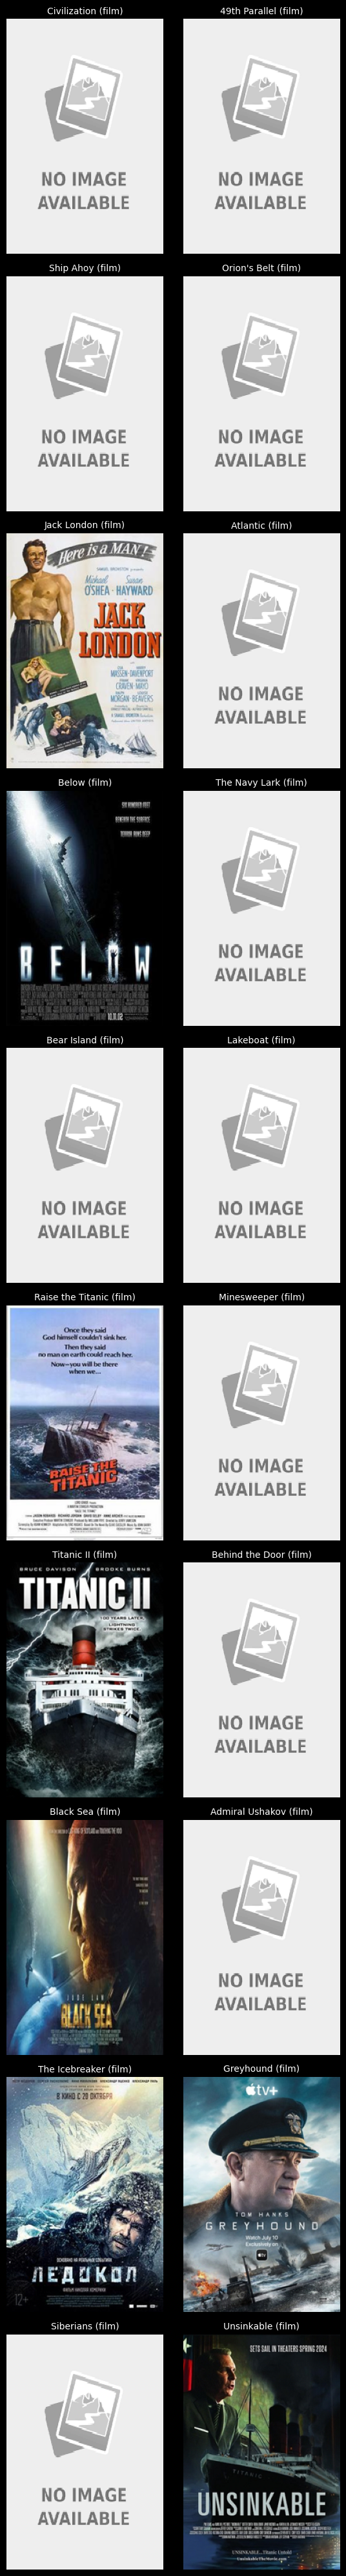

In [163]:
# Test the LLM based recommendation system for a movie name
movie_title = input("Enter a movie title: ")
recommendations = get_recommendations_from_title_llm(movie_title, vector_db, movie_db)
print(f"Recommendations for '{movie_title}':")
print(recommendations)

# Display posters
display_images(recommendations)

### Test the LLM based recommendation system for a movie plot

Querying document with query: movies about a wizard with dangerous powers
Found 20 documents.
Recommendations for plot: 'movies about a wizard with dangerous powers':
             id                          title  \
399      612752                 Wizards (film)   
1845    3903364    Howl's Moving Castle (film)   
3107    8773991                Witchery (film)   
3586   11016612             Simon Magus (film)   
4495   16417244                       P (film)   
4946   19202834                Wingrave (film)   
5049   19821180         Something Weird (film)   
5340   21753206           Witches' Brew (film)   
6589   28196198                   Lokis (film)   
6649   28465893            Magic Island (film)   
7191   31478629  The Magician of Lublin (film)   
7613   33424556        Magic Tree House (film)   
9841   44162467              The Portal (film)   
9912   44370855           Strange Magic (film)   
10209  45506152                  Arcana (film)   
11258  50668190            Witch 

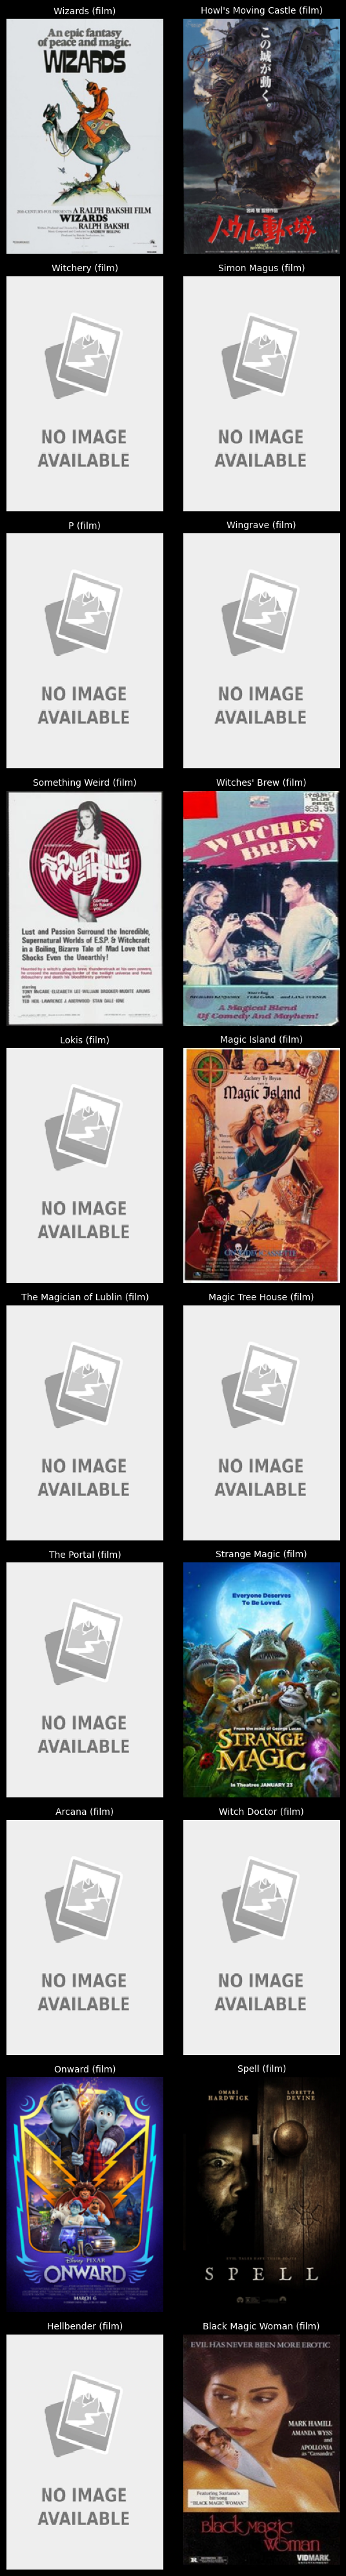

In [164]:
# Test the LLM based recommendation system for a movie plot
default_plot_text = "movies about a wizard with dangerous powers"
plot_text = input(f"Enter a movie plot:")
recommendations = get_recommendations_from_plot_llm(plot_text, vector_db, movie_db)
print(f"Recommendations for plot: '{plot_text}':")
print(recommendations)

# Display posters
display_images(recommendations)

### 2 Dimension visualization

In [187]:
# Get similar documents/movies
import json

def get_movie_titles_with_distance(plot_text, vector_db):
    title_distance_list = []
    
    docs = query_document(plot_text, vector_db)
    for doc in docs:
        match = re.search(r"title:\s+(.*)\n", doc[0].page_content)
        if match:
            title = match.group(1)
        else:
            title = ""
        title_distance_list.append({"title": title, "distance": doc[1]})

    return title_distance_list


In [188]:
# Test function
plot_text = "movies about a wizard with dangerous powers"
title_distance_list = get_movie_titles_with_distance(plot_text, vector_db)
print(title_distance_list)

Querying document with query: movies about a wizard with dangerous powers
Found 20 documents.
[{'title': 'The Portal (film)', 'distance': 0.5506426692008972}, {'title': 'Strange Magic (film)', 'distance': 0.5382795929908752}, {'title': 'Wizards (film)', 'distance': 0.5376755595207214}, {'title': "Howl's Moving Castle (film)", 'distance': 0.5268427133560181}, {'title': 'Spell (film)', 'distance': 0.5207428336143494}, {'title': 'Arcana (film)', 'distance': 0.5077244639396667}, {'title': 'Magic Tree House (film)', 'distance': 0.49552080035209656}, {'title': 'Witchery (film)', 'distance': 0.48930466175079346}, {'title': 'Black Magic Woman (film)', 'distance': 0.4760170876979828}, {'title': 'Hellbender (film)', 'distance': 0.46884337067604065}, {'title': 'Witch Doctor (film)', 'distance': 0.4677771329879761}, {'title': 'Onward (film)', 'distance': 0.46699607372283936}, {'title': 'The Magician of Lublin (film)', 'distance': 0.46580156683921814}, {'title': 'Something Weird (film)', 'distance'

In [264]:
# Get underlying embeddings
from pymilvus import MilvusClient

# Connect to local Milvus database
milvus_client = MilvusClient(uri="data/movies.db")

print(f"available collections = {milvus_client.list_collections()}")

# Initialize embeddings
embeddings = HuggingFaceEmbeddings(
                model_name=model_name,
                model_kwargs=model_kwargs,
                encode_kwargs=encode_kwargs
        )

# Embedding function
def emb_text(embeddings, text):
    """Convert text to an embedding vector."""
    vector = embeddings.embed_query(text)
    return vector

plot_text = "movies about a wizard with dangerous powers"
input_vector = {"title": plot_text, "vector":emb_text(embeddings, plot_text)}

# Search for similar movies and return the text and vector
search_res = milvus_client.search(
    collection_name="LangChainCollection",
    data=[
        emb_text(embeddings, plot_text)
    ],  # Use the `emb_text` function to convert the plot text to an embedding vector
    limit=NO_DOCS_PER_QUERY,  # Return top N results
    search_params={"metric_type": "IP", "params": {}},  # Inner product distance
    output_fields=["text", "vector"],  # Return the text and vector
)

# Process results
result_list = []
for res in search_res[0]:
    match = re.search(r"title:\s+(.*)\n", res["entity"]["text"])
    if match:
        title = match.group(1)
    else:
        title = ""

    print(f"Title: {title}")
    print(f'Vector (partial): {res["entity"]["vector"][:5]}')
    result_list.append({"title": title, "vector": res["entity"]["vector"]})


available collections = ['LangChainCollection']
Title: The Portal (film)
Vector (partial): [0.008449492044746876, 0.026234794408082962, 0.013864786364138126, 0.009052581153810024, 0.01737685315310955]
Title: Strange Magic (film)
Vector (partial): [0.07242519408464432, -0.0036929782945662737, 0.009010011330246925, 0.014824338257312775, -0.0011105346493422985]
Title: Wizards (film)
Vector (partial): [0.01592613384127617, 0.04196617379784584, -0.00415175361558795, 0.02654074691236019, 0.05425088480114937]
Title: Howl's Moving Castle (film)
Vector (partial): [0.055660054087638855, 0.016650516539812088, 0.041886553168296814, 0.03281150013208389, 0.03184489905834198]
Title: Spell (film)
Vector (partial): [0.04088922217488289, 0.00785874854773283, 0.01965949684381485, 0.04081672802567482, 0.009209243580698967]
Title: Arcana (film)
Vector (partial): [-0.022346964105963707, 0.03632834553718567, -0.007973113097250462, 0.06616181880235672, 0.0199603121727705]
Title: Magic Tree House (film)
Vector

[  1.1736379 -12.200127 ]


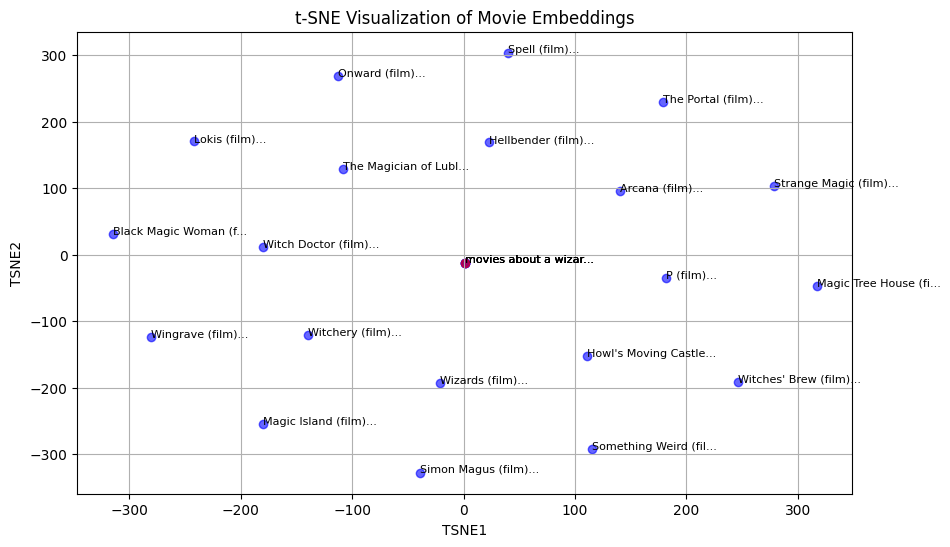

In [269]:
# t-SNE visualization
from sklearn.manifold import TSNE

embedding_vectors = []
result_list.append(input_vector)

for res in result_list:
    embedding_vectors.append(res["vector"])

n_samples = len(embedding_vectors)

X = np.array(embedding_vectors, dtype=np.float32)
tsne = TSNE(random_state=0, max_iter=1000, perplexity=n_samples-1)
tsne_results = tsne.fit_transform(X)

print(tsne_results[-1])

df_tsne = pd.DataFrame(tsne_results[:-1], columns=["TSNE1", "TSNE2"])
df_tsne["Title"] = [res["title"] for res in result_list[:-1]]

df_tsne_input = pd.DataFrame([tsne_results[-1]], columns=["TSNE1", "TSNE2"])
df_tsne_input["Title"] = [res["title"] for res in [result_list[-1]]]

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(df_tsne["TSNE1"], df_tsne["TSNE2"], c="blue", alpha=0.6)
for i, row in df_tsne.iterrows():
    plt.annotate(row["Title"][:20] + "...", (row["TSNE1"], row["TSNE2"]), fontsize=8)

plt.scatter(df_tsne_input["TSNE1"], df_tsne_input["TSNE2"], c="red", alpha=0.6)
# plt.annotate(plot_text, (df_tsne_input["TSNE1"], df_tsne_input["TSNE2"]), fontsize=10)

plt.title("t-SNE Visualization of Movie Embeddings")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.grid(True)
plt.show()


### Films by an actor

In [137]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.tree import Tree

In [138]:
# Download required NLTK datasets (run once)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('maxent_ne_chunker')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
print(nltk.data.path)

['/Users/mahadevgaonkar/nltk_data', '/opt/miniconda3/envs/berkeley_ai/nltk_data', '/opt/miniconda3/envs/berkeley_ai/share/nltk_data', '/opt/miniconda3/envs/berkeley_ai/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mahadevgaonkar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mahadevgaonkar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/mahadevgaonkar/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/mahadevgaonkar/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/mahadevgaonkar/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mahadevgaonkar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downl

In [139]:
# Function to extract names
def extract_actor_names(text):
    # Tokenize and tag parts of speech
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    
    # Extract proper nouns (NNP - singular or compound proper noun)
    actor_names = []
    i = 0
    while i < len(tagged_words):
        if tagged_words[i][1] == "NNP":
            name = tagged_words[i][0]
            i += 1
            # Check if the next word is also a proper noun (for full names)
            if i < len(tagged_words) and tagged_words[i][1] == "NNP":
                name += " " + tagged_words[i][0]
            actor_names.append(name)
        i += 1
    
    return actor_names

Extracted actors: ['Sylvester Stallone', 'Woody Allen']
Error loading image: cannot identify image file <_io.BytesIO object at 0x583b30a40>
Error loading image: cannot identify image file <_io.BytesIO object at 0x583b7bc40>
Error loading image: cannot identify image file <_io.BytesIO object at 0x5839523e0>


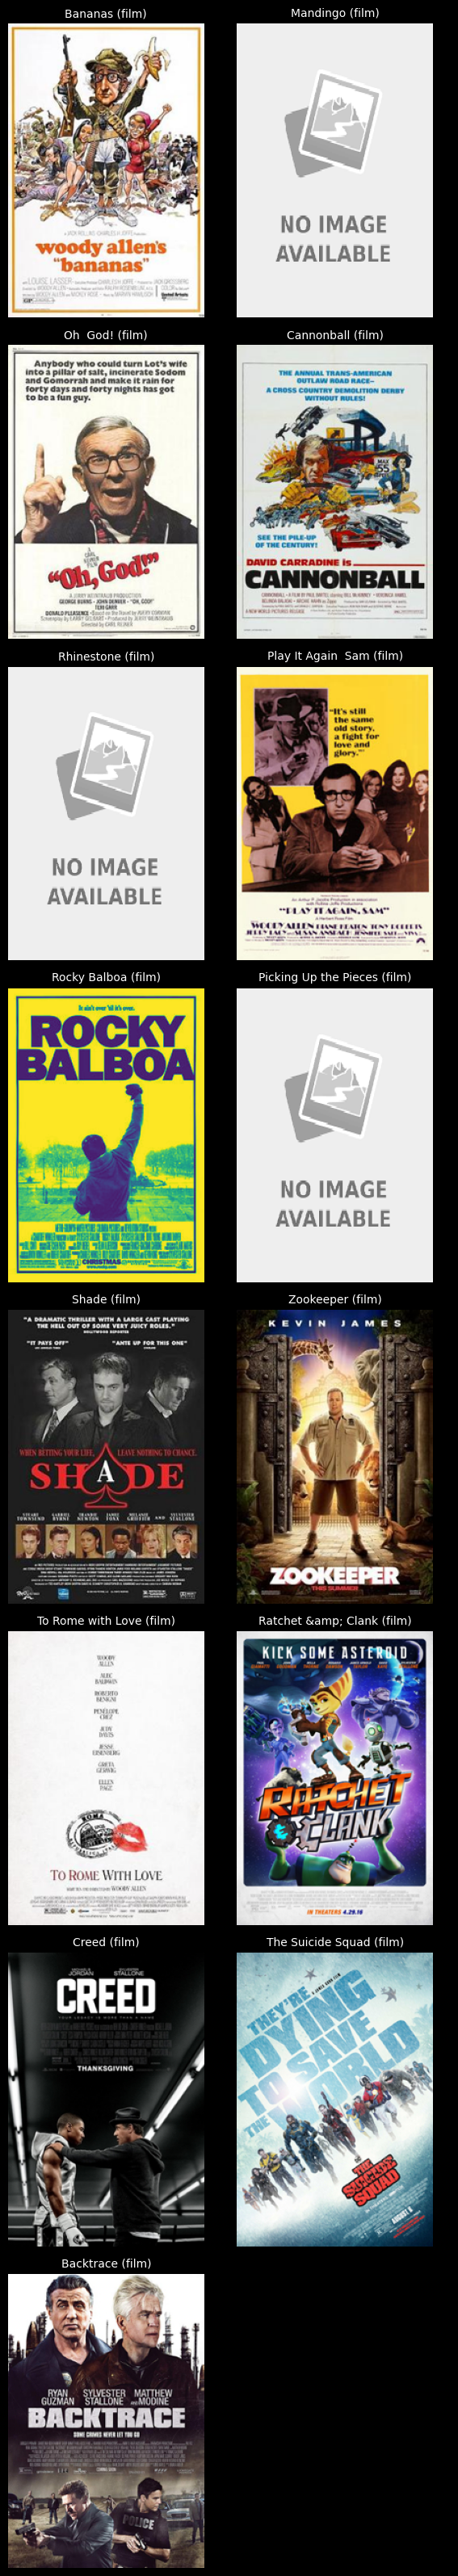

In [140]:
actor_text = "films having Sylvester Stallone, Woody Allen."
actors = extract_actor_names(actor_text)
print(f"Extracted actors: {actors}")
movies = movie_db[movie_db['cast'].str.contains('|'.join(actors), case=False, na=False, regex=True)]

# Display 20 movies with the extracted actors
if movies.empty:
    print("No movies found for the given actor.")
else:
    display_images(movies.head(20))


Extracted actors: ['Tom Cruise']


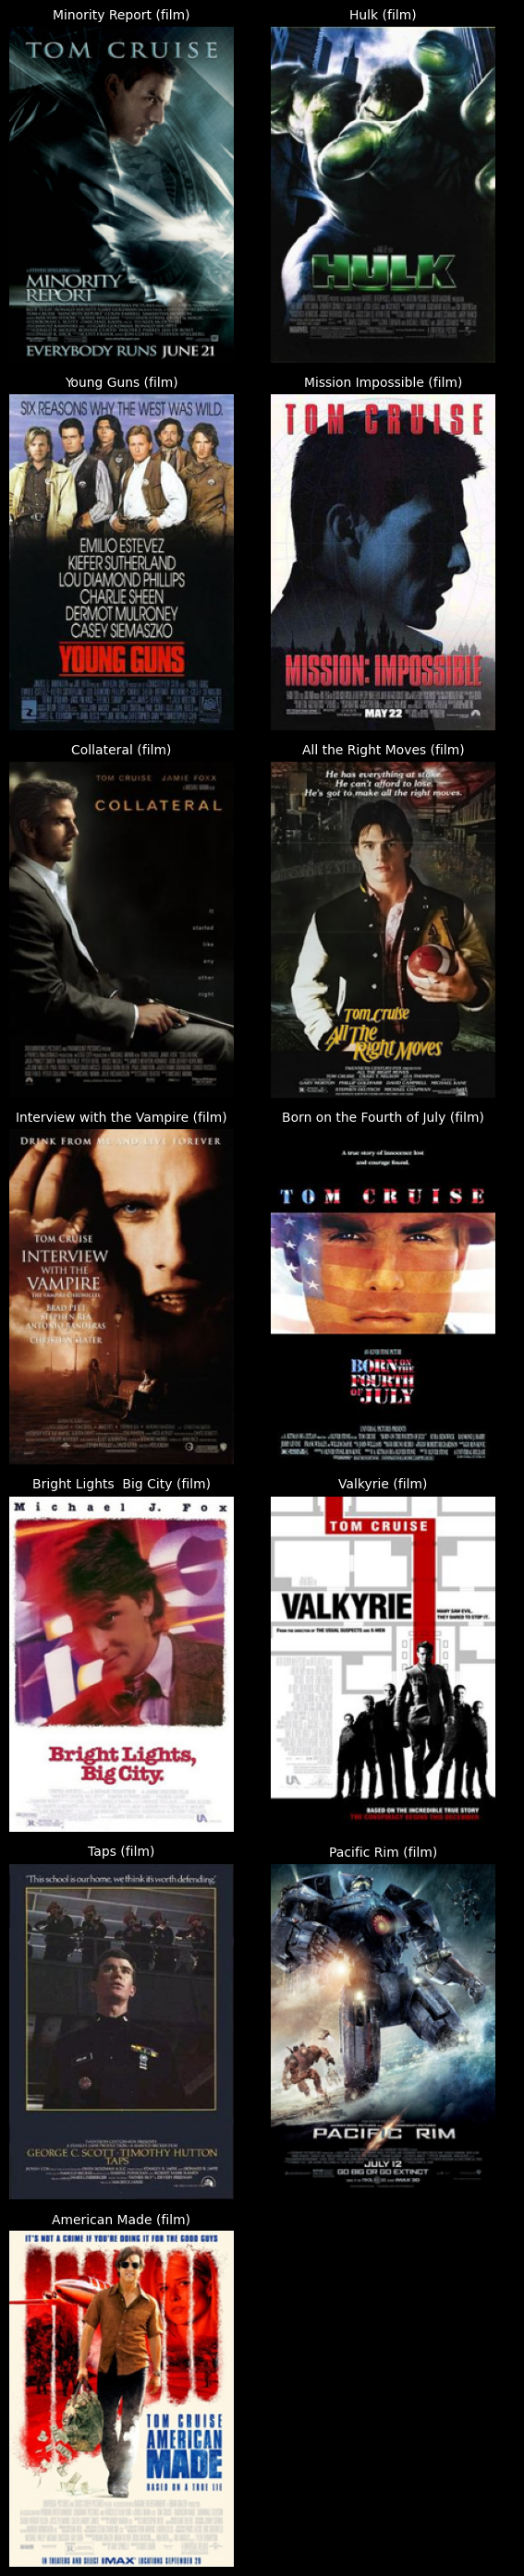

In [141]:
actor_text = "films having Tom Cruise."
actors = extract_actor_names(actor_text)
print(f"Extracted actors: {actors}")
movies = movie_db[movie_db['cast'].str.contains('|'.join(actors), case=False, na=False, regex=True)]
if movies.empty:
    print("No movies found for the given actor.")
else:
    display_images(movies.head(20))